In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

dataDir = './archive/images'

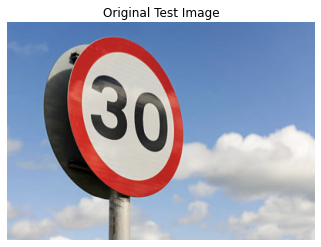

In [36]:
ogImg = cv2.imread(os.path.join(dataDir, 'road120.png'))

ogImg = cv2.cvtColor(ogImg, cv2.COLOR_BGR2RGB)

plt.imshow(ogImg)
plt.title('Original Test Image')
plt.axis('off')
plt.show()

In [41]:
finalImg = ogImg.copy()
testImg = ogImg.copy()
#testImg = cv2.medianBlur(testImg, 5)


# CLAHE

def clahe(testImg):
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    h, s, v = testImg[:,:,0], testImg[:,:,1], testImg[:,:,2]

    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))

    v = clahe.apply(v)

    testImg = np.dstack((h, s, v))

    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImg

# REMOVE SHADOWS

def removeShadows(testImg):
    
    rgb_planes = cv2.split(testImg)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    testImg = cv2.merge(result_norm_planes)
    
    return testImg

#

def redMask(testImg):
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(testImg, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(testImg, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1

    # set my output img to zero everywhere except my mask
    testImgRed = ogImg.copy()
    
    testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_RGB2HSV)
    
    testImgRed[np.where(mask==0)] = 0
    
    testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_HSV2RGB)
    
    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImgRed


# CLOSING

def closing(testImgRed):
    testImgRed = cv2.GaussianBlur(testImgRed, (11,11), 3)
    testImgGray = cv2.cvtColor(testImgRed, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    testImgGray = cv2.morphologyEx(testImgGray, cv2.MORPH_CLOSE, kernel)
    
    cv2.imshow('yo', testImgGray)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return testImgGray



def findCircles(testImgRed):
    # Use the Hough transform to detect circles in the image
    circles = cv2.HoughCircles(testImgRed, cv2.HOUGH_GRADIENT, 1, testImgRed.shape[0] / 8, param1=50, param2=45, minRadius=0, maxRadius=0)
    # If we have extracted a circle, draw an outline
    # We only need to detect one circle here, since there will only be one reference object
    return circles
            
for i in range(3):
    testImg = ogImg.copy()
    if i == 0:
        noShadows = removeShadows(testImg)
        redOnly = redMask(noShadows)
        grayClosing = closing(redOnly)
        circles = findCircles(grayClosing)        
    if i == 1:
        clahe = clahe(testImg)
        redOnly = redMask(clahe)
        grayClosing = closing(redOnly)
        circles = findCircles(grayClosing)
    if i == 2:
        redOnly = redMask(testImg)
        grayClosing = closing(redOnly)
        circles = findCircles(grayClosing)
    print(i)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(finalImg,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(finalImg,(i[0],i[1]),2,(0,0,255),3)
        break
    
# Display the result
finalImg = cv2.cvtColor(finalImg, cv2.COLOR_RGB2BGR)
cv2.imshow('Red Sign', finalImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

0
